## Install Python Driver

Install the python-arango library if not already installed.

In [12]:
!uv pip install torch torchvision timm numpy matplotlib pillow

Resolved 43 packages in 460ms                                        
⠙ Preparing packages... (0/23)                                                  
⠙ Preparing packages... (0/23)------------------     0 B/23.59 KiB           
⠙ Preparing packages... (0/23)0m------------ 14.88 KiB/23.59 KiB         
⠙ Preparing packages... (0/23)0m------------ 14.88 KiB/23.59 KiB         
annotated-doc        ------------------------------     0 B/5.18 KiB
⠙ Preparing packages... (0/23)0m------------ 14.88 KiB/23.59 KiB         
annotated-doc        ------------------------------ 5.18 KiB/5.18 KiB
⠙ Preparing packages... (0/23)0m------------ 14.88 KiB/23.59 KiB         
annotated-doc        ------------------------------ 5.18 KiB/5.18 KiB
⠙ Preparing packages... (0/23)0m------------ 14.88 KiB/23.59 KiB         
annotated-doc        ------------------------------ 5.18 KiB/5.18 KiB
⠙ Preparing packages... (0/23)0m------------ 14.88 KiB/23.59 KiB         
annotated-doc        ---------------------------

# ArangoDB Connection

This notebook demonstrates how to connect to the ArangoDB instance running in Docker.

In [16]:
from arango import ArangoClient

# Initialize the ArangoDB client
client = ArangoClient(hosts='http://localhost:8529')

# Connect to the _system database
sys_db = client.db('_system', username='root', password='rootpassword')

print(f"Connected to ArangoDB version: {sys_db.version()}")

Connected to ArangoDB version: 3.12.7-2


# Databases for image datasets

In [17]:
def create_database(client, db_name, username='root', password='rootpassword'):
    """
    Create or connect to an ArangoDB database
    
    Args:
        client: ArangoDB client
        db_name: Name of the database to create
        username: Database username
        password: Database password
    
    Returns:
        Database connection
    """
    # Connect to _system database (always exists)
    sys_db = client.db('_system', username=username, password=password)
    
    if not sys_db.has_database(db_name):
        sys_db.create_database(db_name)
        print(f"✓ Database '{db_name}' created successfully")
    else:
        print(f"✓ Database '{db_name}' already exists")
    
    # Connect to the database
    db = client.db(db_name, username=username, password=password)
    return db


# Create databases for CIFAR-10 and MNIST
cifar_db = create_database(client, 'cifar_db')
mnist_db = create_database(client, 'mnist_db')

print(f"\n✓ Databases Ready ...")

✓ Database 'cifar_db' already exists
✓ Database 'mnist_db' already exists

✓ Databases Ready ...


# Load Datasets

In [38]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import VisionDataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def load_dataset(dataset_class:VisionDataset, **kwargs):
    """
    Load and prepare a dataset using PyTorch
    
    Args:
        dataset_class: Dataset class (e.g., CIFAR10, MNIST, EMNIST)
        **kwargs: Additional arguments for the dataset (e.g., split='balanced' for EMNIST)
    
    Returns:
        train_images, train_labels, test_images, test_labels, class_names
    """
    # Load dataset using torchvision
    trainset = dataset_class(root='./data', train=True, download=True, **kwargs)
    testset = dataset_class(root='./data', train=False, download=True, **kwargs)
    
    # Get class names from dataset
    class_names = trainset.classes
    dataset_name = dataset_class.__name__
        
    # Convert to numpy arrays
    train_images = np.array([np.array(img) for img, _ in trainset])
    train_labels = np.array([label for _, label in trainset])
    test_images = np.array([np.array(img) for img, _ in testset])
    test_labels = np.array([label for _, label in testset])
    
    print(f"\n{'='*60}")
    print(f"Loaded {dataset_name} Dataset (PyTorch)")
    print(f"{'='*60}")
    print(f"Training set: {train_images.shape[0]} images")
    print(f"Test set: {test_images.shape[0]} images")
    print(f"Image shape: {train_images.shape[1:]}")
    print(f"Classes: {class_names}")
    
    # Display sample images
    plt.figure(figsize=(10, 2))
    count =1
    for i in np.random.randint(0, len(train_images), size=5):
        plt.subplot(1, 5, count)
        # Generic: check if grayscale (2D or single channel) or color
        if len(train_images[i].shape) == 2 or train_images[i].shape[-1] == 1:
            # Grayscale image
            img_to_show = train_images[i][:,:,0] if len(train_images[i].shape) == 3 else train_images[i]
            plt.imshow(img_to_show, cmap='gray')
        else:
            # Color image
            plt.imshow(train_images[i])
        plt.title(class_names[train_labels[i]])
        plt.axis('off')
        count += 1
    plt.tight_layout()
    plt.show()
    
    return train_images, train_labels, test_images, test_labels, class_names

/Users/pedropacheco/Projects/graphrag/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")



Loaded CIFAR100 Dataset (PyTorch)
Training set: 50000 images
Test set: 10000 images
Image shape: (32, 32, 3)
Classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 

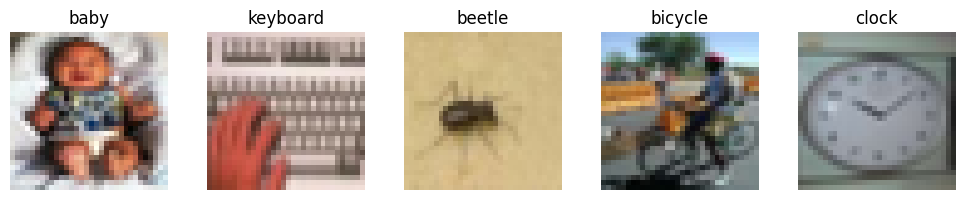

In [39]:
# Load CIFAR-10 dataset
cifar_train_images, cfiar_train_labels, cifar_test_images, cifar_test_labels, cifar_class_names = load_dataset(torchvision.datasets.CIFAR100)


Loaded EMNIST Dataset (PyTorch)
Training set: 112800 images
Test set: 18800 images
Image shape: (28, 28)
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


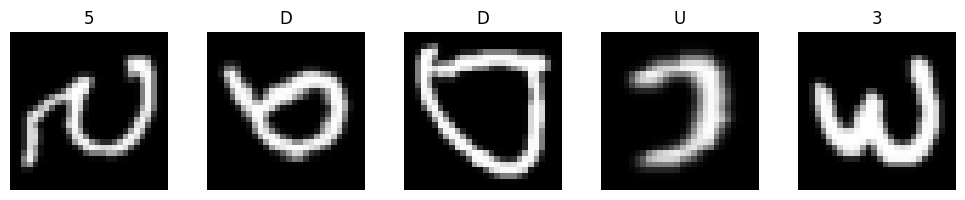

In [43]:
# Load MNIST dataset
mnist_train_images, mnist_train_labels, mnist_test_images, mnist_test_labels, mnist_class_names = load_dataset(torchvision.datasets.EMNIST, split='balanced')

# Store images, labels, and embeddings

In [ ]:
import timm
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

def create_image_embeddings(images, batch_size=32, model_name='resnest50d', device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Extract embeddings from images using ResNeSt model.
    
    Args:
        images: numpy array of images (N, H, W, C) with values in [0, 255]
        batch_size: batch size for processing
        model_name: ResNeSt model variant ('resnest50d', 'resnest101e', 'resnest200e', 'resnest269e')
        device: device to run inference on ('cuda' or 'cpu')
    
    Returns:
        numpy array of embeddings (N, embedding_dim)
    """
    # Load pretrained ResNeSt model from timm
    model = timm.create_model(model_name, pretrained=True, num_classes=0)  # num_classes=0 removes classifier
    model = model.to(device)
    model.eval()
    
    # Preprocessing transform for ImageNet pretrained models
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Process images in batches
    embeddings = []
    
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch_images = images[i:i + batch_size]
            
            # Transform each image in the batch
            batch_tensors = []
            for img in batch_images:
                # Handle grayscale images (convert to RGB)
                if len(img.shape) == 2:
                    img = np.stack([img] * 3, axis=-1)
                elif img.shape[-1] == 1:
                    img = np.repeat(img, 3, axis=-1)
                
                # Apply transformation
                img_tensor = transform(img.astype(np.uint8))
                batch_tensors.append(img_tensor)
            
            # Stack into batch tensor
            batch_tensor = torch.stack(batch_tensors).to(device)
            
            # Forward pass to get embeddings
            batch_embeddings = model(batch_tensor)
            embeddings.append(batch_embeddings.cpu().numpy())
            
            if (i // batch_size + 1) % 10 == 0:
                print(f"Processed {i + batch_size}/{len(images)} images")
    
    # Concatenate all batch embeddings
    embeddings = np.concatenate(embeddings, axis=0)
    
    print(f"✓ Extracted embeddings of shape {embeddings.shape}")
    return embeddings

In [ ]:
def create_collection(db, collection_name):
    """
    Create a collection in ArangoDB with an index on item_id
    
    Args:
        db: ArangoDB database connection
        collection_name: Name of the collection
    
    Returns:
        collection object
    """
    if db.has_collection(collection_name):
        db.delete_collection(collection_name)
        print(f"Deleted existing collection '{collection_name}'")
    
    collection = db.create_collection(collection_name)
    print(f"✓ Created collection '{collection_name}'")
    
    # Create a persistent index on item_id for faster lookups
    collection.add_persistent_index(fields=['item_id'], unique=True)
    print(f"✓ Created persistent index on 'item_id'")
    
    return collection

In [ ]:

from io import BytesIO
import base64

def store_images_with_embeddings(collection, images, labels, embeddings, class_names):
    """
    Store images with their embeddings in ArangoDB
    
    Args:
        collection: ArangoDB collection
        images: numpy array of images
        labels: numpy array of labels
        embeddings: numpy array of embeddings
        class_names: list of class names
    """
    print(f"\n{'='*60}")
    print(f"Storing Images with Embeddings")
    print(f"{'='*60}")    

    documents = []
    for i in range(len(embeddings)):
        # Convert to PIL and encode
        img = Image.fromarray(images[i][:,:,0] if images[i].shape[-1] == 1 else images[i])
        buffered = BytesIO()
        img.save(buffered, format="PNG")
        img_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
        
        doc = {
            'item_id': i,
            'label': int(labels[i]),
            'category': class_names[labels[i]],
            'embedding': embeddings[i].tolist(),
            'image_data': img_base64
        }
        documents.append(doc)
    
    # Insert in batches
    batch_size = 100
    for i in range(0, len(documents), batch_size):
        batch = documents[i:i+batch_size]
        collection.insert_many(batch)
        print(f"Inserted {min(i+batch_size, len(documents))}/{len(documents)} documents", end='\r')
    
    print(f"\n✓ Successfully inserted {len(documents)} images with embeddings")

In [55]:
cifar_collection = create_collection(cifar_db, 'cifar_images')
mnist_collection = create_collection(mnist_db, 'mnist_images')


Deleted existing collection 'cifar_images'
✓ Created collection 'cifar_images'
Deleted existing collection 'mnist_images'
✓ Created collection 'mnist_images'


In [54]:
cifar_embeddings = create_image_embeddings(cifar_train_images, batch_size=32, model_name='resnest50d')
mnist_embeddings = create_image_embeddings(mnist_train_images, batch_size=32, model_name='resnest50d')

Processed 320/50000 images
Processed 640/50000 images
Processed 960/50000 images
Processed 1280/50000 images
Processed 1600/50000 images
Processed 1920/50000 images
Processed 2240/50000 images
Processed 2560/50000 images
Processed 2880/50000 images
Processed 3200/50000 images
Processed 3520/50000 images
Processed 3840/50000 images
Processed 4160/50000 images
Processed 4480/50000 images
Processed 4800/50000 images
Processed 5120/50000 images
Processed 5440/50000 images
Processed 5760/50000 images
Processed 6080/50000 images
Processed 6400/50000 images
Processed 6720/50000 images
Processed 7040/50000 images
Processed 7360/50000 images
Processed 7680/50000 images
Processed 8000/50000 images
Processed 8320/50000 images
Processed 8640/50000 images
Processed 8960/50000 images
Processed 9280/50000 images
Processed 9600/50000 images
Processed 9920/50000 images
Processed 10240/50000 images
Processed 10560/50000 images
Processed 10880/50000 images
Processed 11200/50000 images
Processed 11520/500

In [62]:
store_images_with_embeddings(cifar_collection, cifar_train_images, cfiar_train_labels, cifar_embeddings, cifar_class_names)
store_images_with_embeddings(mnist_collection, mnist_train_images, mnist_train_labels, mnist_embeddings, mnist_class_names)


Storing Images with Embeddings
Inserted 50000/50000 documents
✓ Successfully inserted 50000 images with embeddings

Storing Images with Embeddings
Inserted 112800/112800 documents
✓ Successfully inserted 112800 images with embeddings


In [66]:
def display_image_from_database(db, collection_name, image_id):
    """
    Retrieves image from database and displays

    Args:
        db: ArangoDB database connection
        collection_name: Name of the collection
        image_id: Index of the query image
    """
    # Get the collection
    collection = db.collection(collection_name)
    
    # Use collection.find() to retrieve document by field value
    cursor = collection.find({'item_id': image_id})
    
    # Get the first matching document
    doc = next(cursor, None)
    
    if doc is None:
        print(f"No document found with item_id = {image_id}")
        return None
    
    # Decode and display the image
    img_data = base64.b64decode(doc['image_data'])
    img = Image.open(BytesIO(img_data))
    
    print(f"Item ID: {doc['item_id']}")
    print(f"Label: {doc['label']}")
    print(f"Category: {doc['category']}")
    
    plt.figure(figsize=(4, 4))
    plt.imshow(img, cmap='gray' if img.mode == 'L' else None)
    plt.title(f"{doc['category']} (ID: {doc['item_id']})")
    plt.axis('off')
    plt.show()
    
    return doc


In [80]:
def display_image_from_ndarray(images, image_id, labels=None, class_names=None):
    """
    Display image directly from local numpy array

    Args:
        images: numpy array of images
        image_id: Index of the image to display
        labels: Optional numpy array of labels
        class_names: Optional list of class names
    """
    if image_id < 0 or image_id >= len(images):
        print(f"Image ID {image_id} out of range (0-{len(images)-1})")
        return None
    
    img = images[image_id]
    
    print(f"Item ID: {image_id}")
    if labels is not None:
        print(f"Label: {labels[image_id]}")
    if labels is not None and class_names is not None:
        print(f"Category: {class_names[labels[image_id]]}")
    
    plt.figure(figsize=(4, 4))
    # Handle grayscale images
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    elif img.shape[-1] == 1:
        plt.imshow(img[:,:,0], cmap='gray')
    else:
        plt.imshow(img)
    
    title = f"ID: {image_id}"
    if labels is not None and class_names is not None:
        title = f"{class_names[labels[image_id]]} (ID: {image_id})"
    plt.title(title)
    plt.axis('off')
    plt.show()
    
    return img

# Displays random images from each dataset

Item ID: 47500
Label: 50
Category: mouse


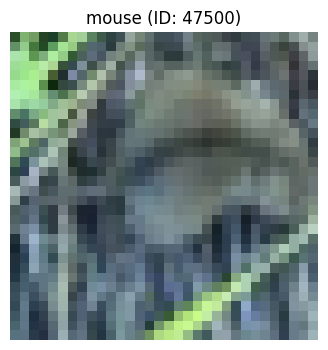

Item ID: 47500


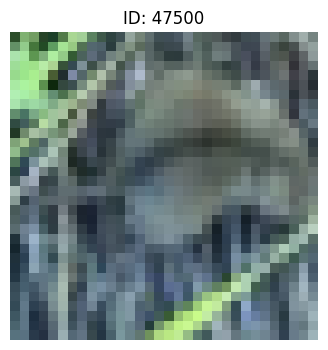

Item ID: 26239
Label: 97
Category: wolf


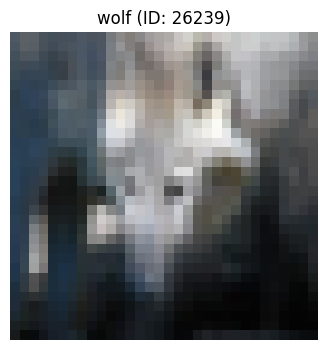

Item ID: 26239


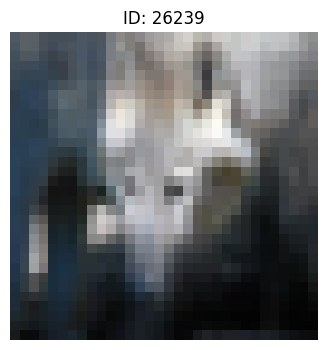

Item ID: 30166
Label: 35
Category: girl


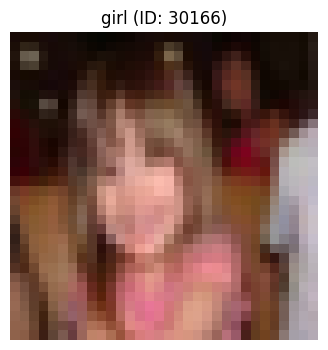

Item ID: 30166


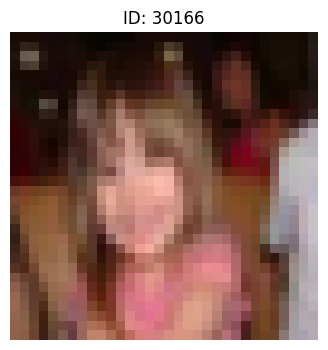

Item ID: 15361
Label: 8
Category: bicycle


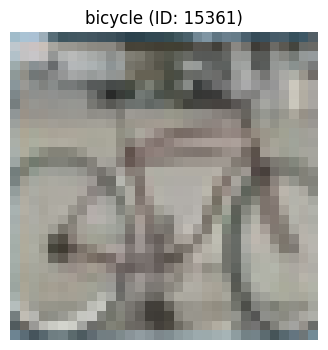

Item ID: 15361


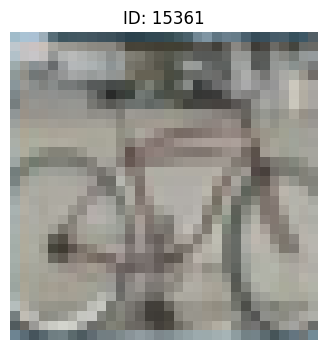

Item ID: 16132
Label: 23
Category: cloud


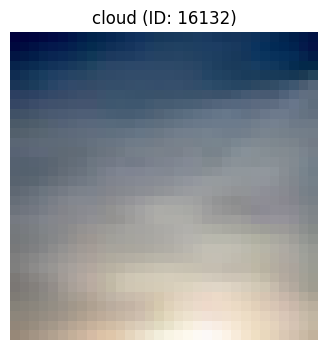

Item ID: 16132


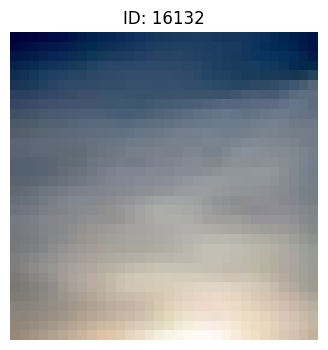

Item ID: 49987
Label: 10
Category: A


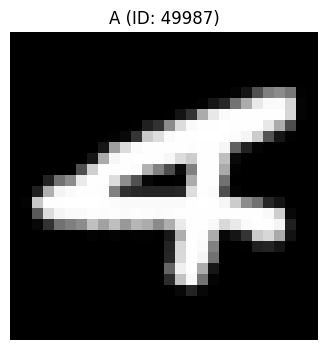

Item ID: 49987


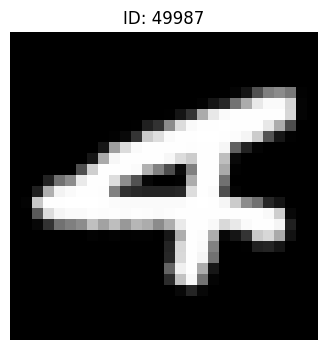

Item ID: 12464
Label: 29
Category: T


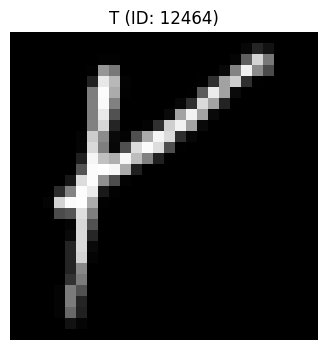

Item ID: 12464


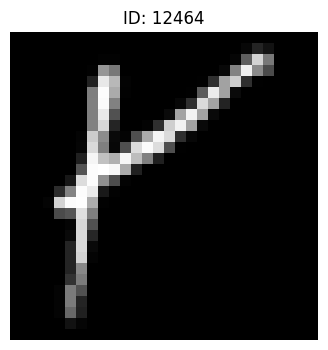

Item ID: 75173
Label: 9
Category: 9


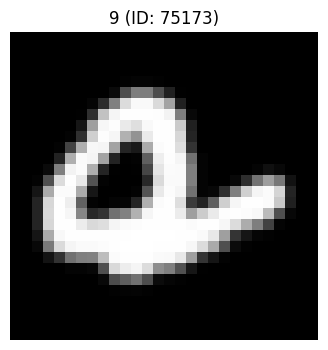

Item ID: 75173


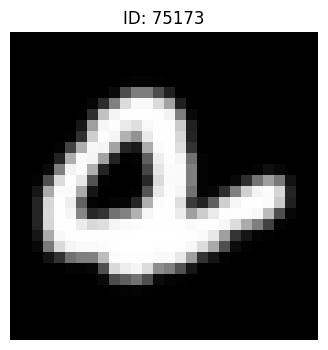

Item ID: 21651
Label: 33
Category: X


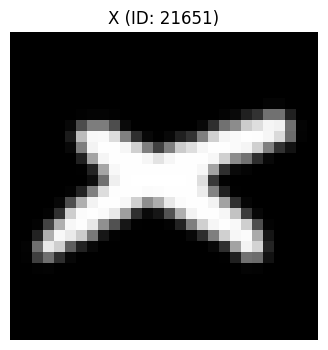

Item ID: 21651


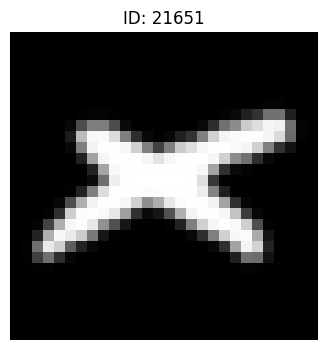

Item ID: 56115
Label: 16
Category: G


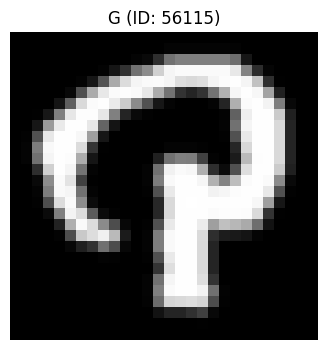

Item ID: 56115


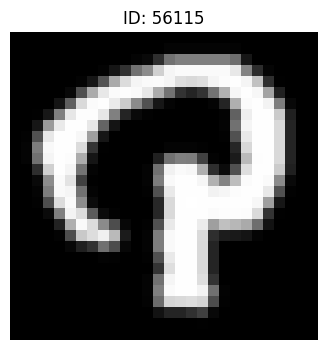

In [81]:
import random
for db, collection_name, images in [(cifar_db, 'cifar_images', cifar_train_images), (mnist_db, 'mnist_images', mnist_train_images)]:
    for i in range(5):
        random_idx = random.randint(0, len(images) - 1)
        display_image_from_database(db, collection_name, random_idx)
        display_image_from_ndarray(images, random_idx)


# Similarity serach using AQL

In [ ]:
def search_similar_images(db, collection_name, query_idx, images, labels, embeddings, class_names, top_k=5):
    """
    Search for similar images using ConvNeXt embeddings
    
    Args:
        db: ArangoDB database connection
        collection_name: Name of the collection
        query_idx: Index of the query image
        images: numpy array of images
        labels: numpy array of labels
        embeddings: numpy array of embeddings
        class_names: list of class names
        top_k: Number of results to return
    """
    query_embedding = embeddings[query_idx].tolist()
    query_label = labels[query_idx]

    print(f"\n{'='*60}")
    print(f"Query #{query_idx}: {class_names[query_label]}")
    print(f"{'='*60}")

    # Display query image
    plt.figure(figsize=(3, 3))
    if images[query_idx].shape[-1] == 1 or len(images[query_idx].shape) == 2:
        plt.imshow(images[query_idx], cmap='gray')
    else:
        plt.imshow(images[query_idx])
    plt.title(f"Query: {class_names[query_label]}")
    plt.axis('off')
    plt.show()

    # AQL query - includes the query image itself for perfect match verification
    aql = '''
    FOR item IN @@collection
        LET similarity = COSINE_SIMILARITY(item.embedding, @query_embedding)
        SORT similarity DESC
        LIMIT @top_k
        RETURN {
            item_id: item.item_id,
            category: item.category,
            similarity: similarity,
            image_data: item.image_data
        }
    '''

    bind_vars = {
        '@collection': collection_name,
        'query_embedding': query_embedding,
        'top_k': top_k
    }

    cursor = db.aql.execute(aql, bind_vars=bind_vars)
    
    # Fetch all results from cursor immediately to avoid exhaustion
    results = [doc for doc in cursor]

    print(f"Top {top_k} semantically similar images:")
    for result in results:
        print(f"  - Item {result['item_id']}: {result['category']} (similarity: {result['similarity']:.4f})")
    
    # Display results - images retrieved from database
    plt.figure(figsize=(12, 3))
    for i, result in enumerate(results):
        # Decode base64 image from database
        img_data = base64.b64decode(result['image_data'])
        img = Image.open(BytesIO(img_data))
        
        plt.subplot(1, top_k, i+1)
        plt.imshow(img, cmap='gray' if img.mode == 'L' else None)
        plt.title(f"{result['category']}\n{result['similarity']:.3f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return results

# Similarity Search Examples

Run similarity searches on random images from CIFAR-100 and MNIST datasets

CIFAR-100 Similarity Search

Query #11269: bottle


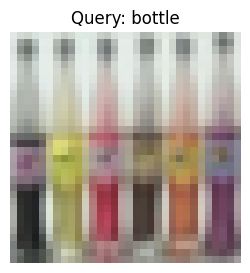

Top 5 semantically similar images:
  - Item 11269: bottle (similarity: 1.0000)
  - Item 39336: bottle (similarity: 0.8178)
  - Item 32145: bottle (similarity: 0.7919)
  - Item 16501: bottle (similarity: 0.7728)
  - Item 36431: bottle (similarity: 0.7667)


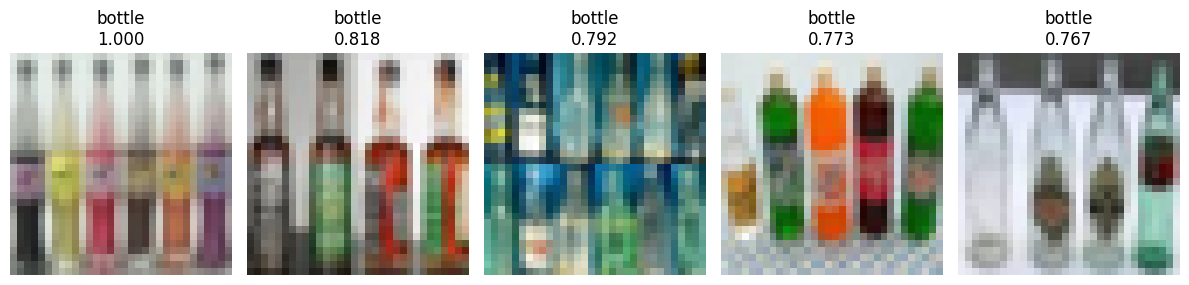


Query #14807: sunflower


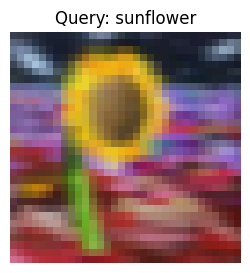

Top 5 semantically similar images:
  - Item 14807: sunflower (similarity: 1.0000)
  - Item 28368: motorcycle (similarity: 0.7288)
  - Item 7026: motorcycle (similarity: 0.7261)
  - Item 34770: lobster (similarity: 0.7218)
  - Item 18081: poppy (similarity: 0.7172)


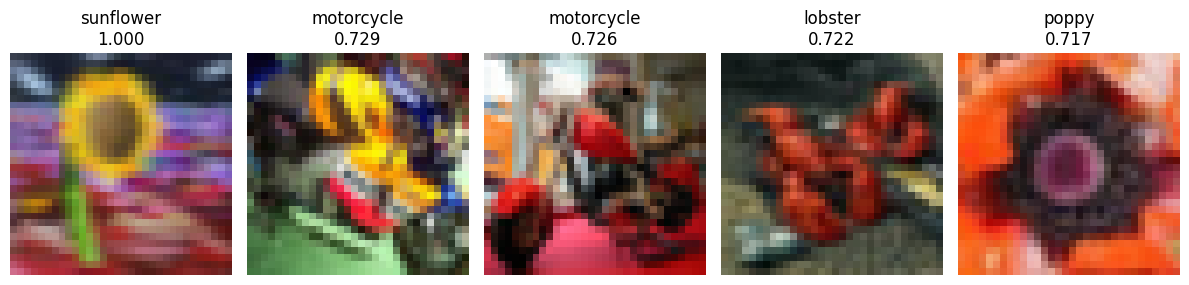


Query #33014: maple_tree


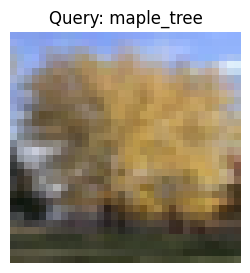

Top 5 semantically similar images:
  - Item 33014: maple_tree (similarity: 1.0000)
  - Item 25483: maple_tree (similarity: 0.9383)
  - Item 48147: maple_tree (similarity: 0.9231)
  - Item 32: maple_tree (similarity: 0.9081)
  - Item 6073: maple_tree (similarity: 0.9049)


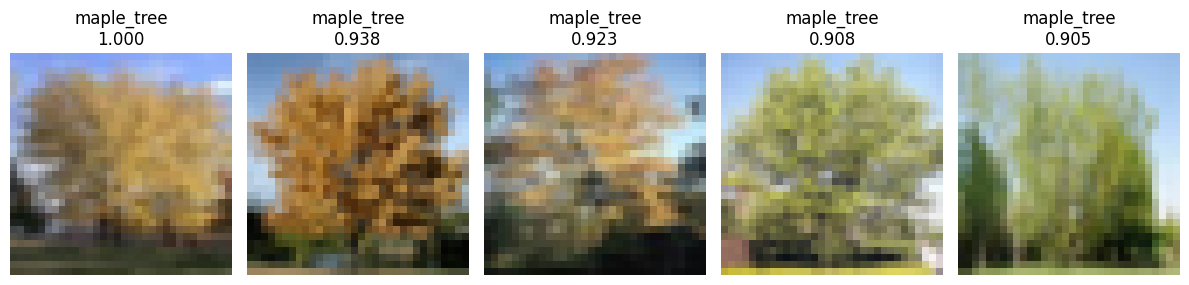


Query #44531: cattle


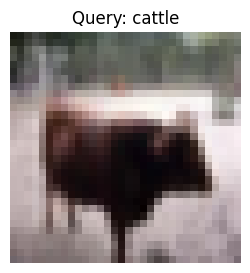

Top 5 semantically similar images:
  - Item 44531: cattle (similarity: 1.0000)
  - Item 35765: cattle (similarity: 0.7994)
  - Item 31384: cattle (similarity: 0.7873)
  - Item 29661: cattle (similarity: 0.7863)
  - Item 22153: cattle (similarity: 0.7761)


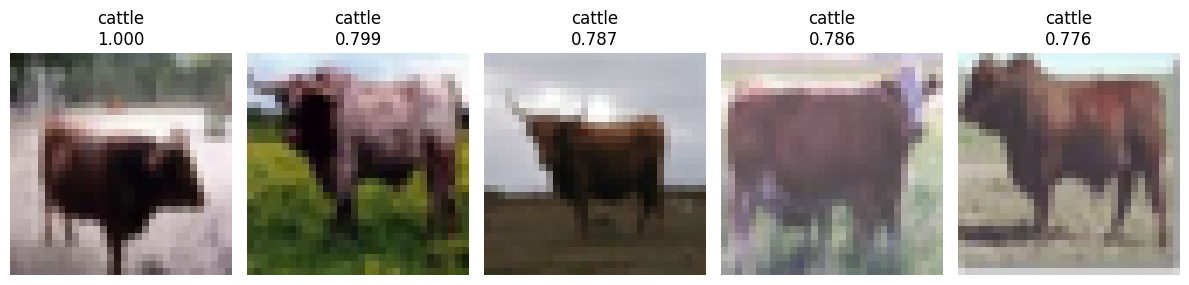


Query #35373: camel


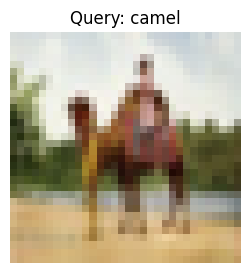

Top 5 semantically similar images:
  - Item 35373: camel (similarity: 1.0000)
  - Item 12326: camel (similarity: 0.7534)
  - Item 17904: camel (similarity: 0.7447)
  - Item 29027: camel (similarity: 0.7424)
  - Item 47771: camel (similarity: 0.7404)


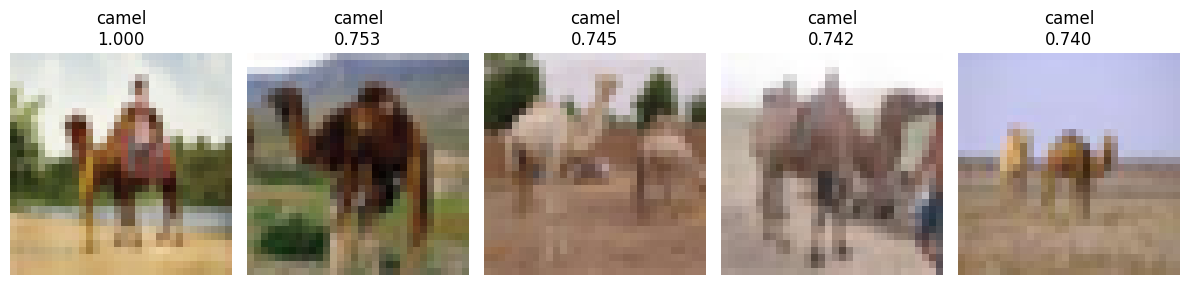

In [ ]:
import random

print("=" * 70)
print("CIFAR-100 Similarity Search")
print("=" * 70)

# Run 5 similarity searches on random CIFAR-100 images
for i in range(5):
    random_idx = random.randint(0, len(cifar_train_images) - 1)
    search_similar_images(
        cifar_db, 
        'cifar_images', 
        random_idx, 
        cifar_train_images, 
        cfiar_train_labels, 
        cifar_embeddings, 
        cifar_class_names,
        top_k=5
    )


MNIST Similarity Search

Query #42610: S


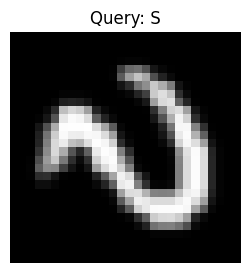

Top 5 semantically similar images:
  - Item 42610: S (similarity: 1.0000)
  - Item 27542: S (similarity: 0.9347)
  - Item 40049: S (similarity: 0.9331)
  - Item 31140: S (similarity: 0.9315)
  - Item 12896: S (similarity: 0.9306)


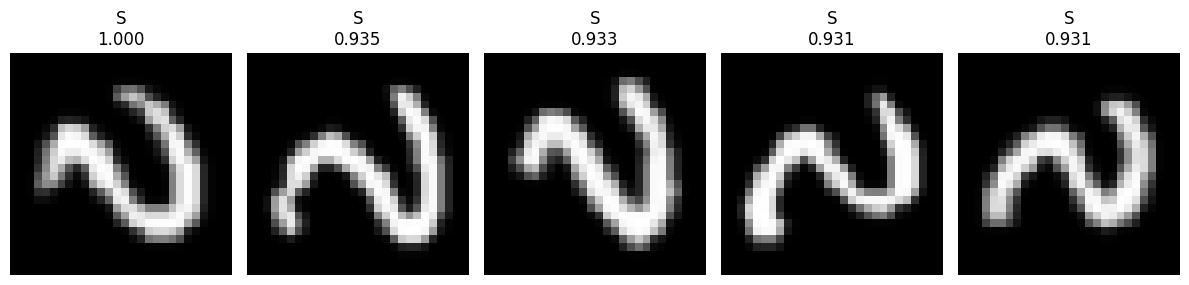


Query #40726: T


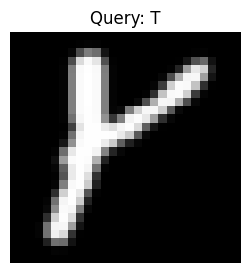

Top 5 semantically similar images:
  - Item 40726: T (similarity: 1.0000)
  - Item 107151: T (similarity: 0.9461)
  - Item 64587: T (similarity: 0.9395)
  - Item 16042: T (similarity: 0.9379)
  - Item 41312: T (similarity: 0.9377)


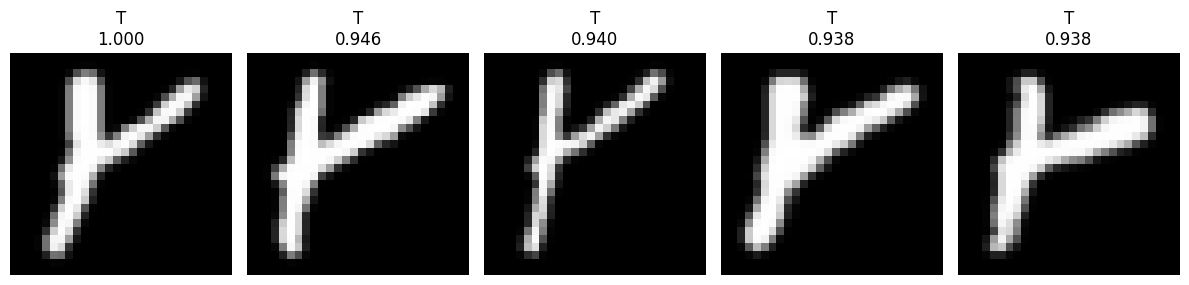


Query #314: r


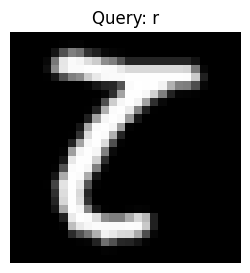

Top 5 semantically similar images:
  - Item 314: r (similarity: 1.0000)
  - Item 67743: n (similarity: 0.9180)
  - Item 104752: r (similarity: 0.9135)
  - Item 53018: h (similarity: 0.9130)
  - Item 7223: N (similarity: 0.9123)


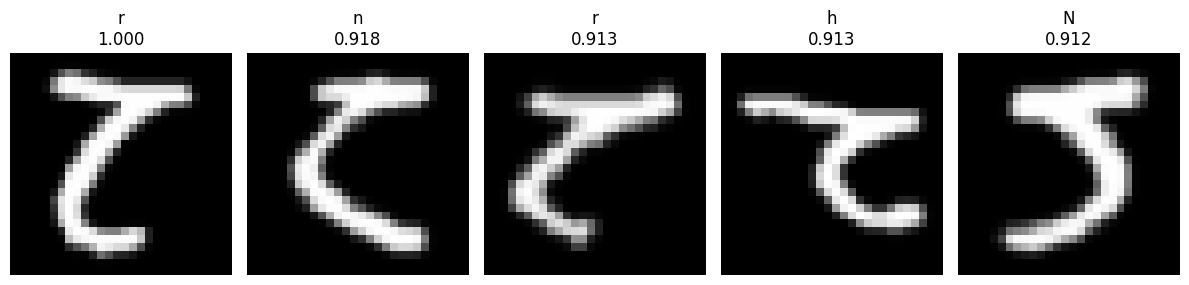


Query #14601: 9


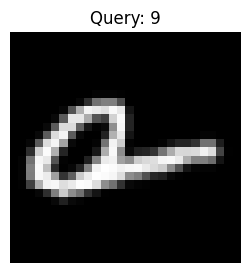

Top 5 semantically similar images:
  - Item 14601: 9 (similarity: 1.0000)
  - Item 17098: 9 (similarity: 0.9626)
  - Item 59625: 9 (similarity: 0.9592)
  - Item 56223: q (similarity: 0.9560)
  - Item 105574: 9 (similarity: 0.9547)


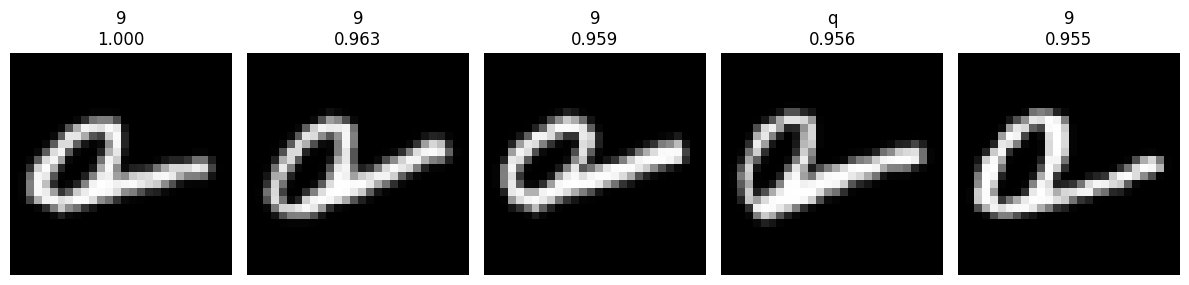


Query #12462: q


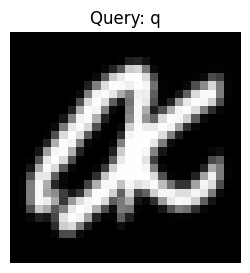

Top 5 semantically similar images:
  - Item 12462: q (similarity: 1.0000)
  - Item 27232: g (similarity: 0.9301)
  - Item 80710: q (similarity: 0.9280)
  - Item 49092: q (similarity: 0.9217)
  - Item 103402: 3 (similarity: 0.9203)


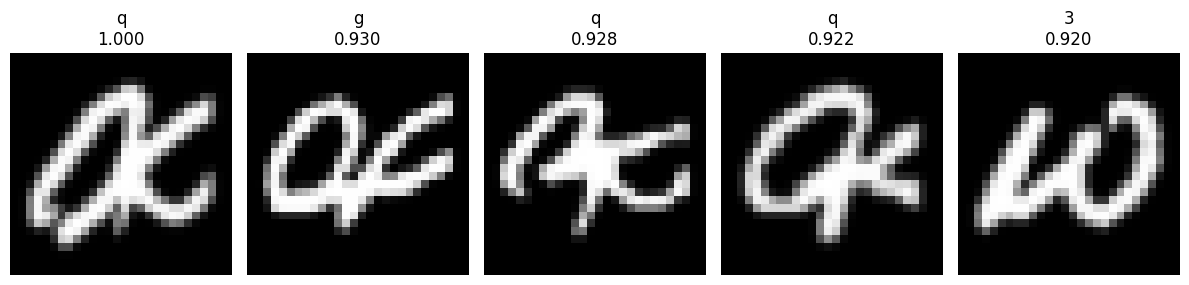

In [ ]:
print("\n" + "=" * 70)
print("MNIST Similarity Search")
print("=" * 70)

# Run 5 similarity searches on random MNIST images
for i in range(5):
    random_idx = random.randint(0, len(mnist_train_images) - 1)
    search_similar_images(
        mnist_db, 
        'mnist_images', 
        random_idx, 
        mnist_train_images, 
        mnist_train_labels, 
        mnist_embeddings, 
        mnist_class_names,
        top_k=5
    )

# Similarity Performance

In [106]:
cifar_test_embeddings = create_image_embeddings(cifar_test_images, batch_size=32, model_name='resnest50d')
mnist_test_embeddings = create_image_embeddings(mnist_test_images, batch_size=32, model_name='resnest50d')

Processed 320/10000 images
Processed 640/10000 images
Processed 960/10000 images
Processed 1280/10000 images
Processed 1600/10000 images
Processed 1920/10000 images
Processed 2240/10000 images
Processed 2560/10000 images
Processed 2880/10000 images
Processed 3200/10000 images
Processed 3520/10000 images
Processed 3840/10000 images
Processed 4160/10000 images
Processed 4480/10000 images
Processed 4800/10000 images
Processed 5120/10000 images
Processed 5440/10000 images
Processed 5760/10000 images
Processed 6080/10000 images
Processed 6400/10000 images
Processed 6720/10000 images
Processed 7040/10000 images
Processed 7360/10000 images
Processed 7680/10000 images
Processed 8000/10000 images
Processed 8320/10000 images
Processed 8640/10000 images
Processed 8960/10000 images
Processed 9280/10000 images
Processed 9600/10000 images
Processed 9920/10000 images
✓ Extracted embeddings of shape (10000, 2048)
Processed 320/18800 images
Processed 640/18800 images
Processed 960/18800 images
Processe

In [107]:
cifar_test_collection = create_collection(cifar_db, 'cifar_test_images')
mnist_test_collection = create_collection(mnist_db, 'mnist_test_images')

✓ Created collection 'cifar_test_images'
✓ Created collection 'mnist_test_images'


In [108]:
store_images_with_embeddings(cifar_test_collection, cifar_test_images, cifar_test_labels, cifar_test_embeddings, cifar_class_names)
store_images_with_embeddings(mnist_test_collection, mnist_test_images, mnist_test_labels, mnist_test_embeddings, mnist_class_names)


Storing Images with Embeddings
Inserted 10000/10000 documents
✓ Successfully inserted 10000 images with embeddings

Storing Images with Embeddings
Inserted 18800/18800 documents
✓ Successfully inserted 18800 images with embeddings



MNIST Test Set Similarity Search

Query #980: 4


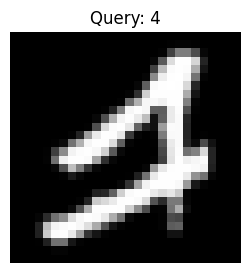

Top 5 semantically similar images:
  - Item 980: 4 (similarity: 1.0000)
  - Item 16237: 4 (similarity: 0.9154)
  - Item 13640: 4 (similarity: 0.9117)
  - Item 10406: 4 (similarity: 0.8977)
  - Item 16635: 4 (similarity: 0.8910)


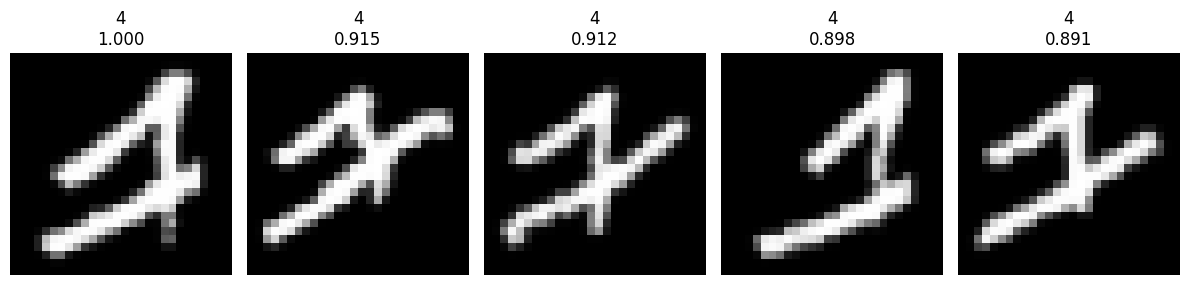


Query #2456: M


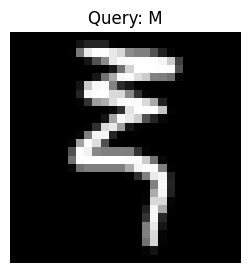

Top 5 semantically similar images:
  - Item 2456: M (similarity: 1.0000)
  - Item 16698: M (similarity: 0.9219)
  - Item 13740: W (similarity: 0.9075)
  - Item 6967: M (similarity: 0.9049)
  - Item 17019: M (similarity: 0.9026)


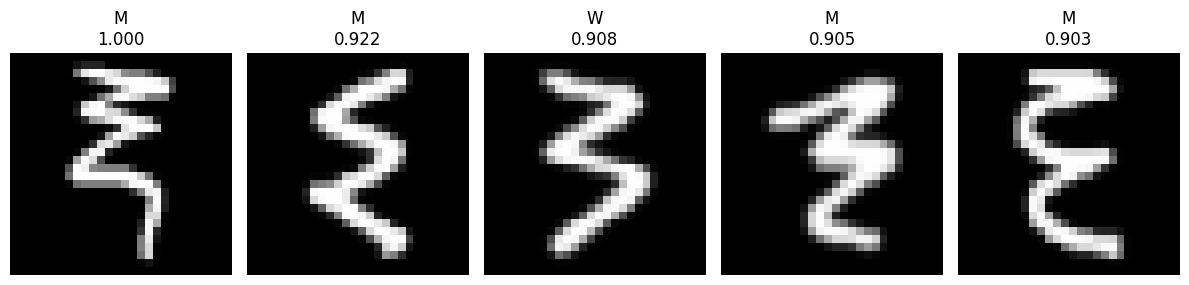


Query #2549: 7


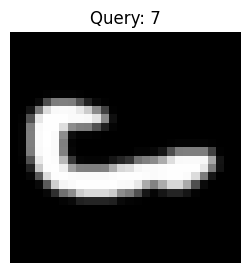

Top 5 semantically similar images:
  - Item 2549: 7 (similarity: 1.0000)
  - Item 16407: Y (similarity: 0.9363)
  - Item 10630: J (similarity: 0.9322)
  - Item 15174: h (similarity: 0.9321)
  - Item 6844: J (similarity: 0.9208)


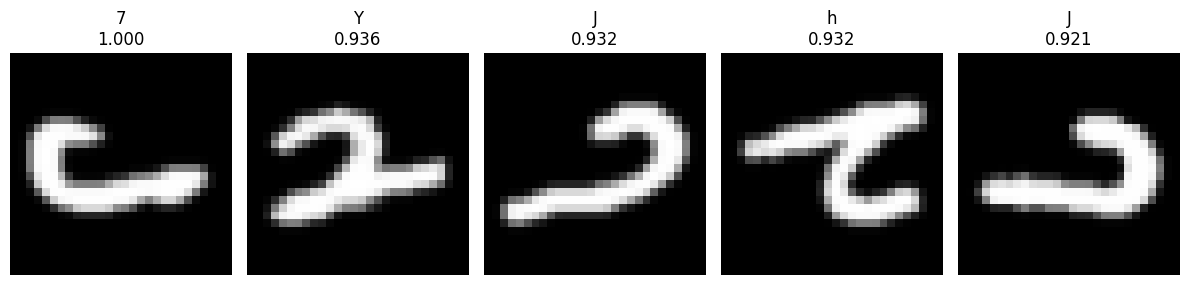


Query #664: A


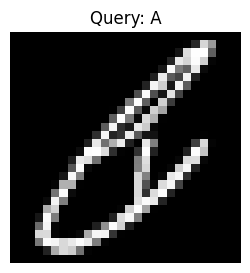

Top 5 semantically similar images:
  - Item 664: A (similarity: 1.0000)
  - Item 3092: A (similarity: 0.9002)
  - Item 3864: A (similarity: 0.8485)
  - Item 1975: B (similarity: 0.8430)
  - Item 18061: A (similarity: 0.8406)


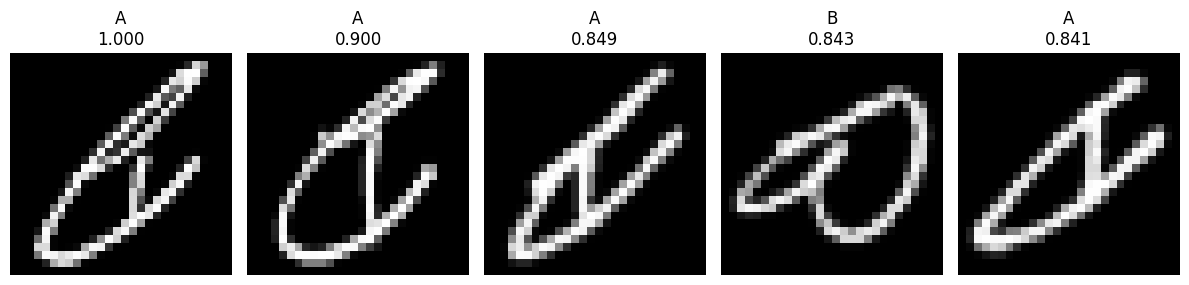


Query #13769: q


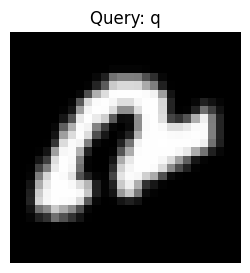

Top 5 semantically similar images:
  - Item 13769: q (similarity: 1.0000)
  - Item 10715: g (similarity: 0.9438)
  - Item 16710: U (similarity: 0.9298)
  - Item 7088: Y (similarity: 0.9283)
  - Item 8751: 6 (similarity: 0.9271)


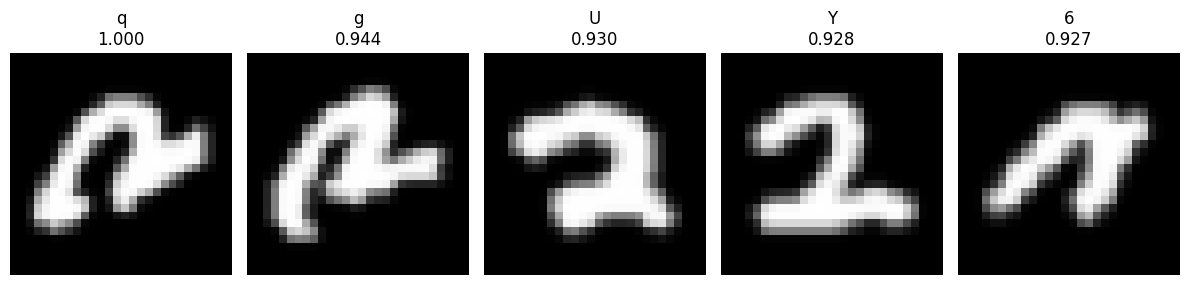

In [119]:
print("\n" + "=" * 70)
print("MNIST Test Set Similarity Search")
print("=" * 70)

# Store results for later analysis
mnist_results = []

# Run 5 similarity searches on random MNIST test images
for i in range(5):
    random_idx = random.randint(0, len(mnist_test_images) - 1)
    results = search_similar_images(
        mnist_db, 
        'mnist_test_images', 
        random_idx, 
        mnist_test_images, 
        mnist_test_labels, 
        mnist_test_embeddings, 
        mnist_class_names,
        top_k=5
    )
    mnist_results.append({
        'query_idx': random_idx,
        'query_label': mnist_test_labels[random_idx],
        'results': results
    })

CIFAR-100 Test Set Similarity Search

Query #4096: dolphin


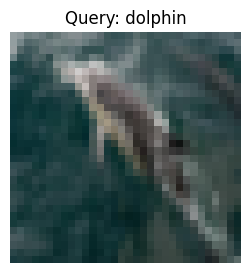

Top 5 semantically similar images:
  - Item 4096: dolphin (similarity: 1.0000)
  - Item 2173: shark (similarity: 0.7694)
  - Item 8608: shark (similarity: 0.7421)
  - Item 552: dolphin (similarity: 0.7378)
  - Item 7599: dolphin (similarity: 0.7317)


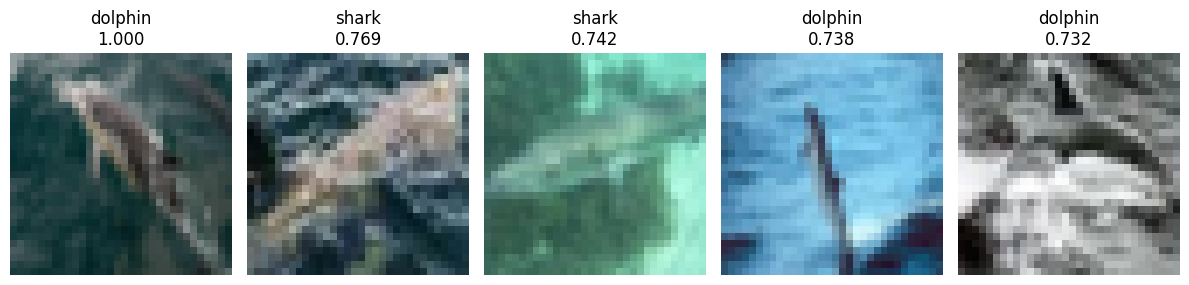


Query #1624: chimpanzee


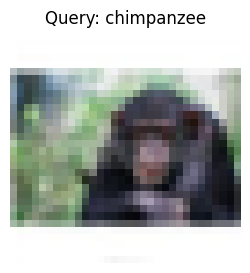

Top 5 semantically similar images:
  - Item 1624: chimpanzee (similarity: 1.0000)
  - Item 5090: chimpanzee (similarity: 0.8251)
  - Item 3442: chimpanzee (similarity: 0.8182)
  - Item 9523: chimpanzee (similarity: 0.8079)
  - Item 6718: chimpanzee (similarity: 0.8051)


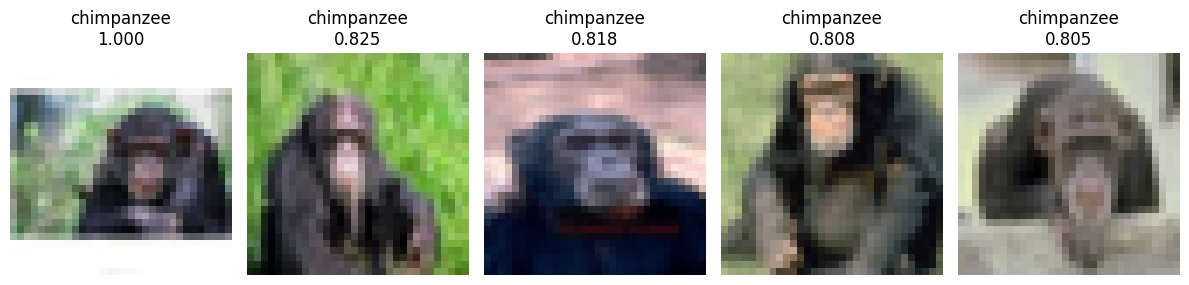


Query #604: lion


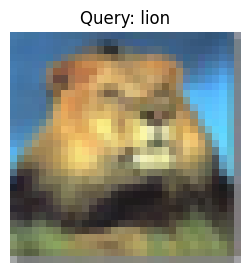

Top 5 semantically similar images:
  - Item 604: lion (similarity: 1.0000)
  - Item 8347: lion (similarity: 0.8318)
  - Item 5027: lion (similarity: 0.8226)
  - Item 3387: lion (similarity: 0.8189)
  - Item 66: lion (similarity: 0.8163)


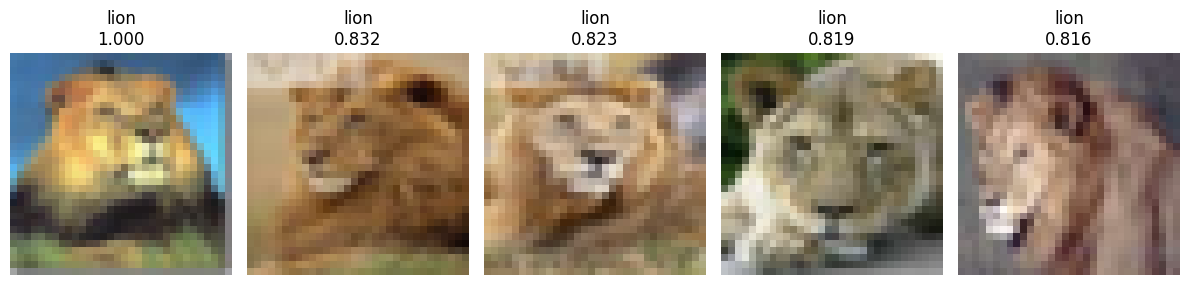


Query #6073: dinosaur


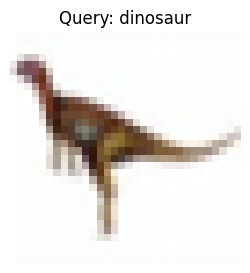

Top 5 semantically similar images:
  - Item 6073: dinosaur (similarity: 1.0000)
  - Item 3987: dinosaur (similarity: 0.8702)
  - Item 7381: dinosaur (similarity: 0.8147)
  - Item 7971: dinosaur (similarity: 0.7676)
  - Item 7712: mouse (similarity: 0.7373)


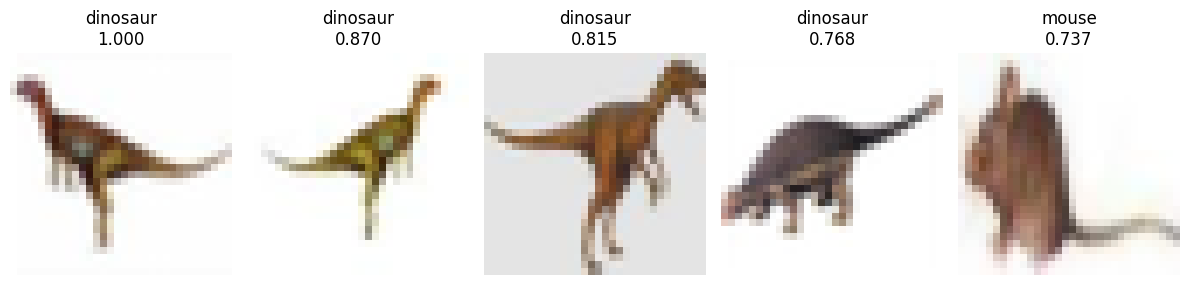


Query #9825: squirrel


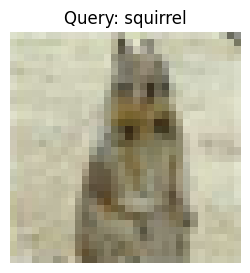

Top 5 semantically similar images:
  - Item 9825: squirrel (similarity: 1.0000)
  - Item 8057: lion (similarity: 0.7524)
  - Item 7411: lion (similarity: 0.7423)
  - Item 3663: wolf (similarity: 0.7253)
  - Item 1515: lion (similarity: 0.7166)


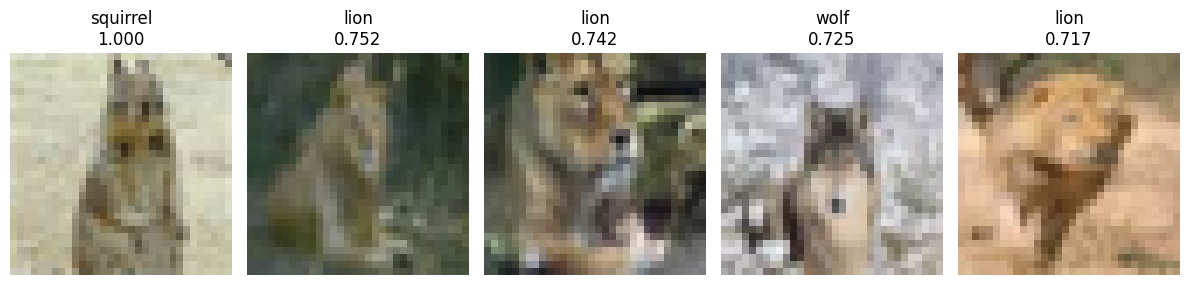

In [117]:
print("=" * 70)
print("CIFAR-100 Test Set Similarity Search")
print("=" * 70)

# Store results for later analysis
cifar_results = []

# Run 5 similarity searches on random CIFAR-100 test images
for i in range(5):
    random_idx = random.randint(0, len(cifar_test_images) - 1)
    results = search_similar_images(
        cifar_db, 
        'cifar_test_images', 
        random_idx, 
        cifar_test_images, 
        cifar_test_labels, 
        cifar_test_embeddings, 
        cifar_class_names,
        top_k=5
    )
    cifar_results.append({
        'query_idx': random_idx,
        'query_label': cifar_test_labels[random_idx],
        'results': results
    })

# Test Set Evaluation

Run similarity searches using test set images as queries against the training set database

# Retrieval Quality Analysis

Evaluate the quality of similarity search results by calculating accuracy and weighted error metrics.

In [ ]:
def calculate_retrieval_metrics(search_results, class_names):
    """
    Calculate retrieval quality metrics for similarity search results.
    
    Metrics:
    - Accuracy: % of retrieved images with matching labels (excluding query itself)
    - Weighted Error: Average similarity scores for incorrect matches
      (high similarity with wrong label = worse error)
    
    Args:
        search_results: List of search result dictionaries with query_idx, query_label, and results
        class_names: List of class names
    
    Returns:
        Dictionary with overall metrics and per-query breakdown
    """
    all_metrics = []
    
    for search in search_results:
        query_label = search['query_label']
        query_category = class_names[query_label]
        results = search['results']
        
        # Skip if results is None or empty
        if results is None or len(results) == 0:
            print(f"Warning: Skipping query {search['query_idx']} - no results found")
            continue
        
        # Skip first result (query itself, should be perfect match)
        similar_results = results[1:]
        
        correct_matches = 0
        incorrect_matches = []
        
        for result in similar_results:
            if result['category'] == query_category:
                correct_matches += 1
            else:
                incorrect_matches.append({
                    'item_id': result['item_id'],
                    'category': result['category'],
                    'similarity': result['similarity']
                })
        
        # Calculate metrics for this query
        accuracy = correct_matches / len(similar_results) if len(similar_results) > 0 else 0
        
        # Weighted error: sum of similarities for wrong matches
        weighted_error = sum(m['similarity'] for m in incorrect_matches) / len(similar_results) if len(similar_results) > 0 else 0
        
        query_metrics = {
            'query_idx': search['query_idx'],
            'query_category': query_category,
            'accuracy': accuracy,
            'weighted_error': weighted_error,
            'correct': correct_matches,
            'incorrect': len(incorrect_matches),
            'total': len(similar_results),
            'incorrect_details': incorrect_matches
        }
        
        all_metrics.append(query_metrics)
    
    # Handle case when all queries failed
    if len(all_metrics) == 0:
        print("\nWarning: No valid search results to analyze!")
        print("Make sure you've run the test collection creation and search cells.")
        return {
            'overall': {
                'avg_accuracy': 0,
                'avg_weighted_error': 0,
                'total_correct': 0,
                'total_incorrect': 0,
                'total_queries': 0,
                'total_retrieved': 0
            },
            'per_query': []
        }
    
    # Calculate overall statistics
    overall = {
        'avg_accuracy': sum(m['accuracy'] for m in all_metrics) / len(all_metrics),
        'avg_weighted_error': sum(m['weighted_error'] for m in all_metrics) / len(all_metrics),
        'total_correct': sum(m['correct'] for m in all_metrics),
        'total_incorrect': sum(m['incorrect'] for m in all_metrics),
        'total_queries': len(all_metrics),
        'total_retrieved': sum(m['total'] for m in all_metrics)
    }
    
    return {
        'overall': overall,
        'per_query': all_metrics
    }

In [ ]:
# Analyze CIFAR-100 retrieval quality
print("=" * 70)
print("CIFAR-100 Retrieval Quality Analysis")
print("=" * 70)

cifar_metrics = calculate_retrieval_metrics(cifar_results, cifar_class_names)

# Overall statistics
overall = cifar_metrics['overall']
print(f"\nOverall Statistics:")
print(f"  - Average Accuracy: {overall['avg_accuracy']*100:.1f}%")
print(f"  - Average Weighted Error: {overall['avg_weighted_error']:.4f} (lower is better)")
print(f"  - Total Correct: {overall['total_correct']}/{overall['total_retrieved']}")
print(f"  - Total Incorrect: {overall['total_incorrect']}")

# Per-query breakdown
print(f"\nPer-Query Breakdown:")
for i, query in enumerate(cifar_metrics['per_query'], 1):
    print(f"\n  Query {i}: {query['query_category']} (ID: {query['query_idx']})")
    print(f"    Accuracy: {query['accuracy']*100:.1f}% ({query['correct']}/{query['total']})")
    print(f"    Weighted Error: {query['weighted_error']:.4f}")
    
    if query['incorrect_details']:
        print(f"    ✗ Incorrect matches:")
        for err in query['incorrect_details']:
            print(f"      - {err['category']} (similarity: {err['similarity']:.4f})")

print(f"\n{'='*70}\n")

CIFAR-100 Retrieval Quality Analysis


ZeroDivisionError: division by zero

In [ ]:
# Analyze MNIST retrieval quality
print("=" * 70)
print("MNIST Retrieval Quality Analysis")
print("=" * 70)

mnist_metrics = calculate_retrieval_metrics(mnist_results, mnist_class_names)

# Overall statistics
overall = mnist_metrics['overall']
print(f"\n📊 Overall Statistics:")
print(f"  - Average Accuracy: {overall['avg_accuracy']*100:.1f}%")
print(f"  - Average Weighted Error: {overall['avg_weighted_error']:.4f} (lower is better)")
print(f"  - Total Correct: {overall['total_correct']}/{overall['total_retrieved']}")
print(f"  - Total Incorrect: {overall['total_incorrect']}")

# Per-query breakdown
print(f"\n📋 Per-Query Breakdown:")
for i, query in enumerate(mnist_metrics['per_query'], 1):
    print(f"\n  Query {i}: {query['query_category']} (ID: {query['query_idx']})")
    print(f"    ✓ Accuracy: {query['accuracy']*100:.1f}% ({query['correct']}/{query['total']})")
    print(f"    ⚠️ Weighted Error: {query['weighted_error']:.4f}")
    
    if query['incorrect_details']:
        print(f"    ✗ Incorrect matches:")
        for err in query['incorrect_details']:
            print(f"      - {err['category']} (similarity: {err['similarity']:.4f})")

print(f"\n{'='*70}\n")